In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch
import os
import torch.utils.data
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np
from torchvision.utils import save_image
%matplotlib inline
from torchvision.models.vgg import vgg16
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

if not os.path.exists("save_image"):
    os.mkdir("save_image")
if not os.path.exists("dataset"):
    os.mkdir("dataset")
if not os.path.exists("asset"):
    os.mkdir("asset")

In [2]:
class DownSizePairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, large_size=256, small_size=64, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Scale(large_size)
        self.small_resizer = transforms.Scale(small_size)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
        return small_img, large_img

In [3]:
train_data = DownSizePairImageFolder('./lfw-deepfunneled/train', transform=transforms.ToTensor())
test_data = DownSizePairImageFolder('./lfw-deepfunneled/test', transform=transforms.ToTensor())
batch_size = 1
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size, shuffle=False, num_workers=4)

torch.Size([3, 256, 256])
1.0 0.0


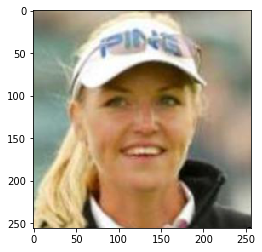

In [4]:
#print( train_data.class_to_idx)
images_lr, images_hr = iter(train_loader).next()
image=images_hr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

torch.Size([3, 64, 64])
1.0 0.003921569


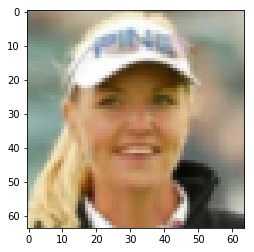

In [5]:
image=images_lr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

In [6]:
class Generator(nn.Module):
    def __init__(self,image_size):
        super(Generator,self).__init__()
        self.image_size=image_size
        
        self.pre_layer=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=9,stride=1,padding=4),
            nn.PReLU())
        
        self.residual_layer=nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64))
        
        self.middle_layer=nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64))
        
        self.pixcelshuffer_layer=nn.Sequential(
            Pixcelshuffer(64,2),
            Pixcelshuffer(64,2),
            nn.Conv2d(64,3,kernel_size=9,stride=1,padding=4))
    def forward(self,input_image):
        pre=self.pre_layer(input_image)
        res=self.residual_layer(pre)
        middle=self.middle_layer(res)
        middle=middle+pre
        output=self.pixcelshuffer_layer(middle)
        
        return output
        
        
        
        
        

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self,input_channel):
        super(ResidualBlock,self).__init__()
        
        self.residualblock=nn.Sequential(
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
            nn.PReLU(),
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel))
    def forward(self,x):
        residual=self.residualblock(x)
        
        return x+residual

In [8]:
class Pixcelshuffer(nn.Module):
    def __init__(self,input_channel,r): #r=upscale_factor
        super(Pixcelshuffer,self).__init__()
        
        self.layer=nn.Sequential(
            nn.Conv2d(input_channel,256,kernel_size=3,stride=1,padding=1), 
            nn.PixelShuffle(r),
            nn.PReLU())
    def forward(self,x):
        return self.layer(x)

In [9]:
test_input=torch.ones(1,3,64,64)
g=Generator(64)
if cuda:
    test_input=test_input.cuda()
    g=g.cuda()
out=g(test_input)
print(out.size())

torch.Size([1, 3, 256, 256])


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.conv_layers=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2))#(512,316,16)
        
        self.dense_layer=nn.Sequential(
            nn.Linear(16*16*512,1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,1),
            nn.Sigmoid())
        
    def forward(self,input_image):
        batch_size=input_image.size()[0]
        
        conv=self.conv_layers(input_image)
        reshape=conv.view(batch_size,-1)
        output=self.dense_layer(reshape)
        
        return output


In [11]:
test_input=torch.ones(1,3,256,256)
d=Discriminator()
if cuda:
    test_input=test_input.cuda()
    d=d.cuda()
out=d(test_input)
print(out.size())

torch.Size([1, 1])


In [12]:
def generator_loss(generated_image,hr_image,d_label,t_label):
    vgg=vgg16(pretrained=True) 
    content_layers=nn.Sequential(*list(vgg.features)[:31]).eval()
    if cuda:
        content_layers=content_layers.cuda()
    for param in content_layers.parameters():
        param.requires_grad=False
    mse_loss=nn.MSELoss()
    content_loss=mse_loss(content_layers(generated_image),content_layers(hr_image))
    
    BCE_loss=nn.BCELoss()
    adversarial_loss=BCE_loss(d_label,t_label)
    
    return content_loss+0.001*adversarial_loss
    

In [13]:
def MSE_Loss(generated_image,hr_image):
    mse_loss=nn.MSELoss()
    image_loss=mse_loss(generated_image,hr_image)
    
    return image_loss

In [14]:
G=Generator(64)
#D=Discriminator()

if cuda:
    G=G.cuda()
    #D=D.cuda()
G_optimizer=optim.Adam(G.parameters(),lr=0.0001,betas=(0.9,0.999))
#D_optimizer=optim.Adam(D.parameters(),lr=0.0001,betas=(0.9,0.999))

#d_loss=nn.BCELoss()

In [ ]:
def first_train(epoch):
    G.train()

    G_loss=0

    for batch_idx,(data_lr,data_hr)in enumerate(train_loader):
        if data_lr.size()[0]!=batch_size:
            break
        if cuda:
            data_lr=data_lr.cuda()
            data_hr=data_hr.cuda()
        fake_image=G(data_lr)
        G.zero_grad()

        G_loss=MSE_Loss(fake_image,data_hr)
        G_loss.backward()
        G_optimizer.step()
        G_loss+=G_loss.data[0]

        G_loss/=len(train_loader)

        g_image=fake_image.data.cpu()
        hr_image=data_hr.data.cpu()
        HR_image=torch.cat((hr_image,g_image),0)
        save_image(HR_image,"save_image/epoch_{}.png".format(epoch))
        print("save_image")

        return G_loss

num_epoch=100

for epoch in range(1,num_epoch+1):
    if epoch==1:
        print("trainning start!!")
    g_loss_=first_train(epoch)

    if epoch%1==0:
        torch.save(G.state_dict(),"asset/G_first_epoch{}.pth".format(epoch))

In [15]:
G=Generator(64)
D=Discriminator()

if cuda:
    G=G.cuda()
    D=D.cuda()

    g_param=torch.load("asset/G.pth")
    G.load_state_dict(g_param)
else:
    g_param=torch.load("asset/G.pth",map_location=lambda storage, loc:storage)
    G.load_state_dict(g_param)

    
G_optimizer=optim.Adam(G.parameters(),lr=0.0001,betas=(0.9,0.999))
D_optimizer=optim.Adam(D.parameters(),lr=0.0001,betas=(0.9,0.999))

d_loss=nn.BCELoss()

In [ ]:
def train(epoch):
    D.train()
    G.train()

    y_real=torch.ones(batch_size,1)
    y_fake=torch.zeros(batch_size,1)

    if cuda:
        y_real=y_real.cuda()
        y_fake=y_fake.cuda()

        D_loss=0
        G_loss=0

    for batch_idx,(data_lr,data_hr)in enumerate(train_loader):
        if data_lr.size()[0]!=batch_size:
            break
        if cuda:
            data_lr=data_lr.cuda()
            data_hr=data_hr.cuda()
        print(batch_idx)
        D.zero_grad()

        D_real=D(data_hr)
        D_real_loss=d_loss(D_real,y_real)

        fake_image=G(data_lr)
        D_fake=D(fake_image)
        D_fake_loss=d_loss(D_fake,y_fake)

        D_loss=D_real_loss+D_fake_loss
        D_loss.backward(retain_graph=True)
        D_optimizer.step()
        D_loss+=D_loss.data[0]

        G.zero_grad()

        G_loss=generator_loss(fake_image,data_hr,D_fake,y_real)
        print(G_loss,D_loss)
        G_loss.backward()
        G_optimizer.step()
        G_loss+=G_loss.data[0]

        D_loss/=len(train_loader)
        G_loss/=len(train_loader)

        if batch_idx%1==0:
            g_image=fake_image.data.cpu()
            hr_image=data_hr.data.cpu()
            HR_image=torch.cat((hr_image,g_image),0)
            save_image(HR_image,"save_image/epoch_cont_{}.png".format(epoch))
            print("save_image")

        return D_loss,G_loss

num_epoch=10000

for epoch in range(1,num_epoch+1):
    if epoch==1:
        print("trainning start!!")
    d_loss_,g_loss_=train(epoch)

    if epoch%40==0:
        #generate_image(epoch)
        torch.save(G.state_dict(),"asset/G_2nd_epoch{}.pth".format(epoch))
        torch.save(D.state_dict(),"asset/D_2nd_epoch{}.pth".format(epoch))

trainning start!!
0


In [17]:
test_loader = DataLoader(test_data, batch_size, shuffle=True)
images_lr, images_hr = iter(test_loader).next()
generated_image=G(images_lr)
bl_recon=torch.nn.functional.upsample(images_lr,256,mode="bilinear")

/Users/Username/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [20]:
save_image(torch.cat([images_hr,bl_recon.cpu(),generated_image.cpu()],0),"asset/result1.jpg")